#Atividade 1 - Evolução de Software

# Equipe 3:
- Adicley de Oliveira Costa
- Alíria de Santana Amorim Cruz
- Herbert Barreto Freire
- Iago Soares de Macedo
- Letícia Caroline da Silva Oliveira
- Lucas Aragão Damaceno
- Rodrigo Nunes de Santana

# Instalação das bibliotecas para a atividade

In [ ]:
!pip install transformers matplotlib numpy

#Leitura do arquivo de comentários extraidos das pull requests utilizando o script

- Função utilizada para leitura dos arquivos .json para a atividade

In [ ]:
import json as js

def read_file(path):
    with open(path, 'r') as f:
        data = js.load(f)
    return data

- Leitura dos arquivos e geração do vetor de respostas para os modelos

In [ ]:
pr_comments = read_file('pr_comments.json')
models_resp = []

# Importação das classes pipeline e AutoModelForSequenceClassification, e listagem dos modelos que serão utilizados na atividade

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification

models = ["clapAI/modernBERT-large-multilingual-sentiment",
          "lxyuan/distilbert-base-multilingual-cased-sentiments-student",
          "clapAI/roberta-large-multilingual-sentiment"]

# Classificação dos comentários utlizando os modelos

In [ ]:
task = "text-classification"

def comments_classifier(pipe, pr_id, comments, array_template):
    pr_comments_classification_template = {'pr_id': pr_id, 'comments_classified': []}
    for comment in comments:
        txt_comment = comment['comment']
        answer = pipe(txt_comment)
        classification = answer[0]['label']
        classification_template = {'author': comment['login'], 'author_association': comment['author_association'],
                                   'comment': txt_comment, 'sentiment_analysis': classification.lower()}
        pr_comments_classification_template['comments_classified'].append(classification_template)
    array_template.append(pr_comments_classification_template)

for model_name in models:
    array_template = {'model_name': model_name, 'comments_classifier': []}
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    pipe = pipeline(model=model_name, task=task, truncation=True, max_length=model.config.max_position_embeddings-2)
    print(f"model_name: {model_name}")
    print("pr_id:", end=' ')
    for pr_comment in pr_comments:
        pr_id = pr_comment['pr_id']
        print(pr_id, end=' ')
        comments_classifier(pipe, pr_id, pr_comment['comments'], array_template['comments_classifier'])
    print("\n")
    models_resp.append(array_template)

- Salva os dados dos comentários classificados para cada modelo

In [ ]:
with open('pr_comments_classified.json', 'w') as f:
    js.dump(models_resp, f, indent=4)

#Geração das tabelas para uma análise resumida dos dados coletados das pull requests

- Função utlizada para plotar os gráficos de barra para análise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bar_graph(x_params, list_scores, width, labels, colors, **args):
    plt.figure()
    arr = np.array([2*num for num in range(len(x_params))])

    for i in range(len(labels)):
        list_labels = [p[i] for p in list_scores]
        bar_plt = plt.bar(arr+i*width, list_labels, width, label=labels[i], color=colors[i])
        plt.bar_label(bar_plt, labels=list_labels, label_type="edge")

    plt.title(args['title'])
    plt.xlabel(args['x_label'])
    plt.ylabel(args['y_label'])
    plt.xticks(arr+width, x_params, fontsize=args['fontsize'])
    plt.legend()
    plt.show()

- Geração da lista de desempenho dos modelos em positivo, negativo ou neutro

In [ ]:
#Leitura do arquivo contendo as classificações;
data = read_file('pr_comments_classified.json')

#[Positive, Negative, Neutral]
models_performace_array = []

for model_data in data:
    pr_comments_classified = model_data['comments_classifier']
    performace_template = {'positive': 0, 'negative': 0, 'neutral': 0}
    for comments in pr_comments_classified:
        list_comments = comments['comments_classified']
        if not list_comments:
            continue
        for comment in list_comments:
            sentiment_analysis = comment['sentiment_analysis']
            score = performace_template[sentiment_analysis]
            score = score + 1
            performace_template[sentiment_analysis] = score
    array = [performace_template['positive'], performace_template['negative'], performace_template['neutral']]
    models_performace_array.append(array)

- Geração da tabela de desempenho individual de cada modelos, divididos em positivo, negativo ou neutro

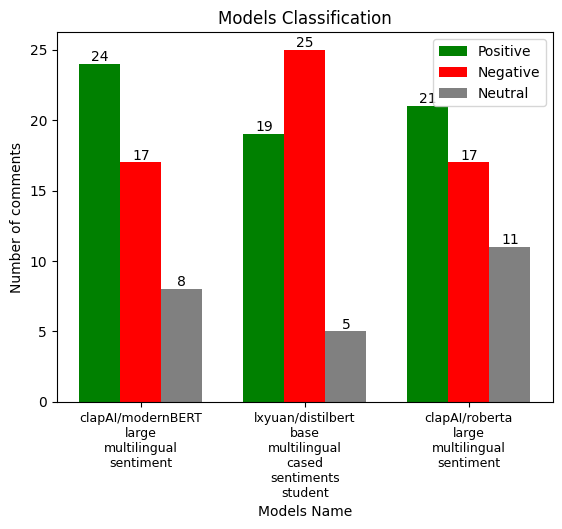

In [ ]:
width = 0.5
labels = ["Positive", "Negative", "Neutral"]
colors = ["Green", "Red", "Gray"]

params = {
    'title': "Models Classification",
    'x_label': "Models Name",
    'y_label': "Number of comments",
    'fontsize': 9
}
_models = [models[i].replace("-", "\n") for i in range(len(models))]
plot_bar_graph(_models, models_performace_array, width, labels, colors, **params)

- Análise de sentimento dos contribuidores mais ativos do projeto de acordo para cada modelo escolhido

In [ ]:
models_author_classification = []

# Contribuidores que mais deram commits no projeto: "anything-llm"
contributors = ["timothycarambat", "shatfield4", "angelplusultra"]

classification_map = {'positive': 0, 'negative': 1, 'neutral': 2}

for model_data in data:
    model_name = model_data['model_name']
    contributors_hashmap = {contributors[i]: [0, 0, 0] for i in range(len(contributors))}
    model_author_mapping = {'model_name': model_name, 'classification': contributors_hashmap}
    pr_comments_classified = model_data['comments_classifier']

    for comments in pr_comments_classified:
        list_comments = comments['comments_classified']
        if not list_comments:
            continue
        for comment in list_comments:
            author = comment['author']

            if author not in contributors_hashmap:
                continue

            classification = contributors_hashmap[author]
            sentiment = comment['sentiment_analysis']
            index = classification_map[sentiment]
            classification[index] = classification[index] + 1

    models_author_classification.append(model_author_mapping)

- Geração das tabelas dos contribuidores com suas respectivasd classificações dadas por cada modelo

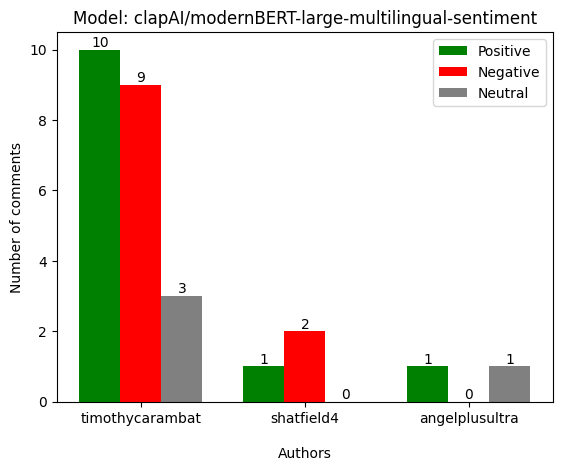

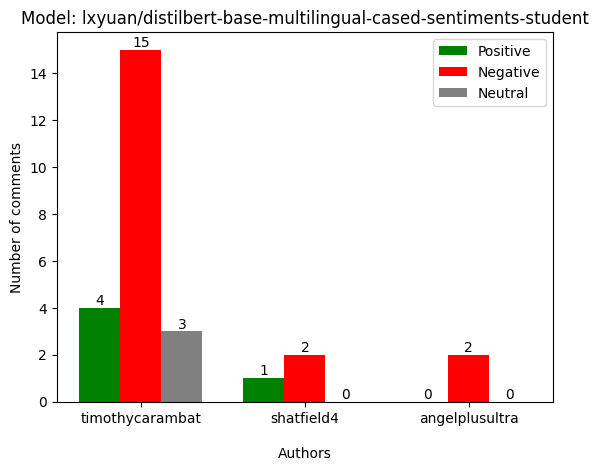

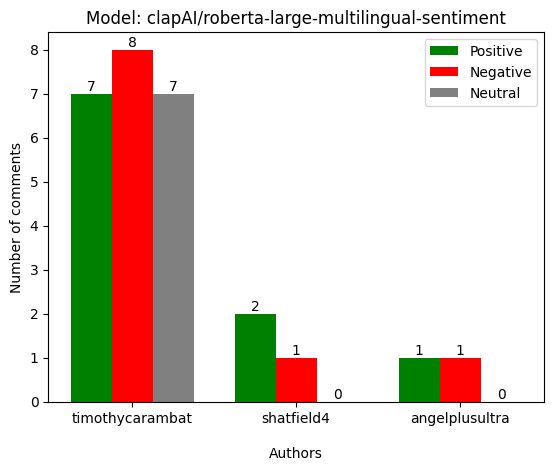

In [ ]:
for i in range(len(models)):
    model_name = models_author_classification[i]['model_name']

    classifications = []

    for _ , c in models_author_classification[i]['classification'].items():
        classifications.append(c)

    params = {
        'title': f"Model: {model_name}",
        'x_label': "\nAuthors",
        'y_label': "Number of comments",
        'fontsize': 10
    }

    plot_bar_graph(contributors, classifications, width, labels, colors, **params)